In [1]:
import os
import tensorflow as tf

num_threads = 30
os.environ["OMP_NUM_THREADS"] = "5"
os.environ["TF_NUM_INTRAOP_THREADS"] = "5"
os.environ["TF_NUM_INTEROP_THREADS"] = "5"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

from tensorflow.keras import models, layers
import uproot
import numpy as np
import pandas as pd

NUMEPOCHS = 20
PHASEMAX = 100
PERCENTPILEUP = 0.5
NUMTRAINING = 0
ModelOutputName = 'triad_1000e'


In [2]:


def GetData(filename, treename="timing"):
    '''
    Returns TFile as a pandas dataframe
    '''
    file = uproot.open(filename)
    print(file.keys())
    tree = file[treename]
    npdf = tree.arrays(library="np")
    df =  pd.DataFrame(npdf, columns=npdf.keys())
    return df


def PlotTraces(traces, n=10):
    '''
    plot n random traces from the traces array
    '''
    import matplotlib.pyplot as plt
    time = np.arange(0, 600.0, 2.0)
    fig = plt.figure(figsize=(10, 5))
    for i in range(n):
        rand_idx = np.random.randint(0, traces.shape[0])
        plt.plot(time, traces[rand_idx][:], label="Trace {}".format(rand_idx))
    plt.plot([0, 600], [0, 0], 'k-', lw=2)
    plt.grid()
    plt.xlabel("Time (ns)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.show()

def GetTraces(values,traceLength=300):
    traces = np.zeros((values.shape[0], traceLength))
    for i in range(values.shape[0]):
        trace = np.array(values[i]).reshape(traceLength, 1)
        traces[i][:] = trace[:, 0]
    return traces

def NormalizeTraces(traces):
    ''' 
    Normailze traces to have a max of 1 and a min of 0
    '''
    
    for i in range(traces.shape[0]):
        min_before_peak = np.min(traces[i][:100])
        traces[i][:] = traces[i][:] - min_before_peak
        
    return traces / np.max(traces, axis=1)[:, None]

def NormalizeTraces2(traces):
    for i in range(traces.shape[0]):
        baseline = np.average(traces[i][0:40])
        traces[i] -= baseline
        tmax = np.amax(traces[i])
        traces[i] /= tmax
    return traces

def OneHotEndocePileup(pileup):
    pileup_one_hot = np.zeros((pileup.shape[0], 2))
    for i in range(pileup.shape[0]):
        if pileup[i]:
            pileup_one_hot[i][:] = [1, 0]
        else:
            pileup_one_hot[i][:] = [0, 1]
    return pileup_one_hot

def GetPhases(phases):
    phase = np.zeros((phases.shape[0], 1))
    for i in range(phases.shape[0]):
        if phases[i] > 0:
            phase[i] = phases[i]
        else:
            phase[i] = 0.0
    return phase
    
def PlotPhasesAndTrace(traces, phases, onehot, n =10):
    import matplotlib.pyplot as plt
    time = np.arange(0, 600.0, 2.0)
    ygrid = n//5
    if n%5 != 0:
        ygrid += 1
    fig, ax = plt.subplots(ygrid, 5 ,figsize=(20, ygrid*3), sharex=True, sharey=True)
    for i in range(n):
        rand_idx = np.random.randint(0, traces.shape[0])
        ax[i//5, i%5].plot(time, traces[rand_idx][:], label="Trace {}".format(rand_idx))
        ax[i//5, i%5].plot([0, 600], [0, 0], 'k-', lw=2)
        if i%5 == 0:
            ax[i//5, i%5].set_ylabel("Amplitude (mV)")
        if i//5 == ygrid-1:
            ax[i//5, i%5].set_xlabel("Time (ns)")
            
        ax[i//5, i%5].set_xlim(0, 600)
        ax[i//5, i%5].set_ylim(-0.1, 1.15)
        ax[i//5, i%5].text(0.05, 0.9, "Trace #{}".format(rand_idx), fontsize=10, color='black', transform=ax[i//5, i%5].transAxes,fontweight='bold')
        if onehot[rand_idx][0]:
            ax[i//5, i%5].text(0.55, 0.9, "Shift: {0:.2f} ns".format(phases[rand_idx][0]), fontsize=10, color='blue', transform=ax[i//5, i%5].transAxes)
        else:
            ax[i//5, i%5].text(0.55, 0.9, "No Pileup", fontsize=10, color='red', transform=ax[i//5, i%5].transAxes)
    plt.show()
    


# def PhaseNet():
#     input = layers.Input(shape=(300,1))
#     conv1 = layers.Conv1D(kernel_size=10, filters=64, activation='tanh')(input)
#     max1 = layers.MaxPooling1D(pool_size=1)(conv1)
#     conv2 = layers.Conv1D(kernel_size=10, filters=64, activation='relu')(max1)
#     max2 = layers.MaxPooling1D(pool_size=1)(conv2)
#     conv3 = layers.Conv1D(kernel_size=1, filters=64, activation='relu')(max2)
#     max3 = layers.MaxPooling1D(pool_size=1)(conv3)
#     conv4 = layers.Conv1D(kernel_size=2, filters=64, activation='relu', padding='same')(max3)
#     max4 = layers.MaxPooling1D(pool_size=10)(conv4)
    
#     flat1 = layers.Flatten()(max4)
#     dense1 = layers.Dense(264, activation='relu')(flat1)
#     dense2 = layers.Dense(128, activation='relu')(dense1)
#     dense3 = layers.Dense(64, activation='relu')(dense2)
#     output = layers.Dense(1, activation='linear')(dense3)
    
#     model = models.Model(inputs=input, outputs=output)
#     model.summary()
    
#     return model

# filename = 'ysoLabr3975V.root'
# tree = 'timing'
# traceBranch = "traceone"
# traceLength = 300
# # pdf = GetData("ysoTracesWithPileup.root",'timing')
# # pdf = pdf[pdf["trace"].apply(lambda x: x.shape[0] == 300)].reset_index(drop=True)
# # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
# # phase_shifts = GetPhases(pdf["phase"].values)
# # traces = GetTraces(pdf["trace"].values)
# pdf = GetData(filename,tree)
# pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
# pdf = pdf[pdf["qdcone"].apply(lambda x: x > 100000 and x<250000)].reset_index(drop=True)
# # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
# # phase_shifts = GetPhases(pdf["phase"].values)
# traces = GetTraces(pdf[traceBranch].values,traceLength)

In [3]:
def getRandomPileupTraces(tt1,tt2,rndphase,scale):
  newtot = np.zeros_like(tt1)
  newtt1 = np.zeros_like(tt1)
  newtt2 = np.zeros_like(tt2)
  std2 = np.std(tt2[:60]) # gets deviation for baseline
  for i in range(len(tt1)):
    newtt1[i] = tt1[i]
    if(i<rndphase):
      newtot[i] = tt1[i]
      newtt2[i] = np.random.normal(0,std2) # gaussian random for baseline
    else:
      i2 = int(i-rndphase)
      newtt2[i] = (tt2[i2+1]-tt2[i2])*(rndphase-int(rndphase))+tt2[i2]
      newtt2[i] *= scale
      newtot[i] = tt1[i] + newtt2[i]
  max = np.max(newtot)
  nmin = np.min(newtot)
  min = newtt2[-1] if newtt1[-1]>newtt2[-1] else  newtt1[-1] #normalizes bottom
  scale = max-nmin
  # print(max,nmin,min,scale)
  return (newtot)/max,newtt1/max,newtt2/max

def augmentTraces(dataset,numAugs,labels=None,otherdata=None,otherdata2=None,otherdata3=None):
  newData = []
  newLabels = []
  newOther = []
  newOther2 = []
  newOther3 = []
  for iter in range(len(dataset)):
    for i in range(numAugs):
      newData.append(dataset[iter][4*i:-4*numAugs+4*i])
      newLabels.append(labels[iter])
      newOther.append(otherdata[iter])
      newOther2.append(otherdata2[iter])
      newOther3.append(otherdata3[iter])
  newData = np.array(newData)
  newLabels = np.array(newLabels)
  newOther = np.array(newOther)
  newOther2 = np.array(newOther2)
  newOther3 = np.array(newOther3)
  return newData, newLabels, newOther, newOther2, newOther3

In [4]:
# traces_no_pileup = pdf["trace"].values[pdf["pileup"].values == False]
# traces_with_pileup = pdf["trace"].values[pdf["pileup"].values == True]
# rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
# rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
# rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

# phase_amplitude = np.zeros((traces_no_pileup.shape[0], 2))
# traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, 300))
# traces_piledup = np.zeros((traces_no_pileup.shape[0], 300,1))

# for i in range(traces_no_pileup.shape[0]):
#     if rand_ifPile[i]<PERCENTPILEUP:
#         rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
#         traces_piledup[i][:,0],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:300],traces_no_pileup[rand_trace][:300],rand_phase_shifts[i],rand_amplitude_shifts[i])
#         phase_amplitude[i][0] = rand_phase_shifts[i]
#         phase_amplitude[i][1] = rand_amplitude_shifts[i]
#     else:
#         traces_piledup[i][:,0] = traces_no_pileup[i][:300]
#         traces_depiled[i][0][:] = traces_no_pileup[i][:300]
#         traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:300])
#         phase_amplitude[i][0] = 0.
#         phase_amplitude[i][1] = 0.


# for i in range(traces_no_pileup.shape[0]):
#     traces_piledup[i][:,0] = traces_depiled[i][0][:] + traces_depiled[i][1][:]
#     am = np.max(traces_piledup[i][:,0])
#     traces_piledup[i][:,0] = traces_piledup[i][:,0] / am
#     traces_depiled[i][0][:] = traces_depiled[i][0][:] / am
#     traces_depiled[i][1][:] = traces_depiled[i][1][:] / am

# new_traces_with_pileup = []
# for t in traces_with_pileup:
#   nt = t.flatten()
#   new_traces_with_pileup.append(nt)


In [8]:
import re
from itertools import chain

NUMEPOCHS = 1000
PHASEMAX = 100
PERCENTPILEUP = 0.5
NUMTRAINING = 20000
ModelOutputName = 'triad_1000e'
AUGMENTATION = 8
TRACELENGTH = 1000

# dir = 'data/lyso950V/'
# files = ['pileup10600ps.root','pileup11760ps.root','pileup1326ps.root','pileup18350ps.root','pileup20840ps.root','pileup2125ps.root','pileup23180ps.root','pileup27700ps.root','pileup36700ps.root','pileup3735ps.root','pileup46100ps.root','pileup55300ps.root','pileup9246ps.root','pileup9660ps.root','pileup0.root','pileup0Oscilloscope.root','pileup0Pixie.root']
# dir2 = 'data/lyso1100V/'
# files2 = ['newPileup1270ps.root','newPileup13000ps.root','newPileup14100ps.root','newPileup18400ps.root','newPileup19000ps.root','newPileup2490ps.root','newPileup27700ps.root','newPileup32600ps.root','newPileup3740ps.root','newPileup46200ps.root','newPileup4880ps.root','newPileup9280ps.root','newPileup9660ps.root','newPileup0.root','newPileup0Oscilloscope.root','newPileup0Pixie.root']
# zeroFiles = ['pileup0.root','pileup0Oscilloscope.root','pileup0Pixie.root','newPileup0.root','newPileup0Oscilloscope.root','newPileup0Pixie.root']
dir = 'data/lyso210Po/'
files = ['lysoPileup241AmnoAmp.root']
# files = ['lysoPileup0nsFIFOnoAmp.root']
# files = ['lysoPileup0nsFIFOnoAmp.root','lysoPileup10nsFIFO5xAmp.root','lysoPileup10nsFIFOnoAmp.root','lysoPileup1_5nsFIFOnoAmp.root','lysoPileup5nsFIFOnoAmp.root']
traces = []
phases = []
ifPile = []
qdcs = []
amps = []
for f in files:
    fname = dir+f
    tree = 'data'
    traceBranch = "traceone"
    traceLength = 1000
    if f=='lysoPileup10nsFIFO5xAmp.root':
        phase = 10.0
    elif f=='lysoPileup1_5nsFIFOnoAmp.root':
        phase = 1.5
    elif f=='lysoPileup241AmnoAmp.root':
        phase = 1.5
        traceLength=250
    else:
        phase = float(re.sub('\D','',f))
    # phase = float(re.sub('\D','',f))/1000
    print(phase)
    print(fname)
    pdf = GetData(fname,tree)
    print(pdf.size)
    pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
    print(pdf.size)
    # pdf = pdf[pdf["qdcone"].apply(lambda x: x > 100000 and x<250000)].reset_index(drop=True)
    # # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
    qdcs.append(GetPhases(pdf["qdcone"].values))
    tt = GetTraces(pdf[traceBranch].values,traceLength)
    traces.append(tt)
    phases.append(np.full((len(tt),1),phase))
    ifPile.append(np.full((len(tt),1),phase>0))
    amps.append(np.full((len(tt),1),phase>0).astype(np.float))


1.5
data/lyso210Po/lysoPileup241AmnoAmp.root
['data;67', 'data;66']
160290000
159238599


In [9]:

# for f in files2:
#     fname = dir2+f
#     tree = 'data'
#     traceBranch = "traceone"
#     traceLength = 250
#     phase = float(re.sub('\D','',f))/1000
#     print(phase)
#     pdf = GetData(fname,tree)
#     pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)
#     # pdf = pdf[pdf["qdcone"].apply(lambda x: x > 100000 and x<250000)].reset_index(drop=True)
#     # # pile_up_one_hot = OneHotEndocePileup(pdf["pileup"].values)
#     qdcs.append(GetPhases(pdf["qdcone"].values))
#     tt = GetTraces(pdf[traceBranch].values,traceLength)
#     traces.append(tt)
#     phases.append(np.full((len(tt),1),phase))
#     ifPile.append(np.full((len(tt),1),phase>0))
#     amps.append(np.full((len(tt),1),phase>0).astype(np.float))

# for i in range(len(zeroFiles)):
#     f = zeroFiles[i]
#     d = dir if i<3 else dir2
#     fname = d+f
#     tree = 'data'
#     traceBranch = "traceone"
#     traceLength = 250
#     phase = float(re.sub('\D','',f))/1000
#     print(phase)
#     pdf = GetData(fname,tree)
#     pdf = pdf[pdf[traceBranch].apply(lambda x: x.shape[0] == traceLength)].reset_index(drop=True)

#     traces_no_pileup = GetTraces(pdf[traceBranch].values,traceLength)
    # rand_phase_shifts = np.random.uniform(0.1, PHASEMAX, traces_no_pileup.shape[0])
    # rand_amplitude_shifts = np.random.uniform(0.5, 1.5, traces_no_pileup.shape[0])
    # rand_ifPile = np.random.uniform(0, 1, traces_no_pileup.shape[0])

    # pp = np.zeros((traces_no_pileup.shape[0], 1))
    # aa = np.zeros((traces_no_pileup.shape[0], 1))
    # ip = np.zeros((traces_no_pileup.shape[0], 1))
    # traces_depiled = np.zeros((traces_no_pileup.shape[0], 2, TRACELENGTH))
    # traces_piledup = np.zeros((traces_no_pileup.shape[0], TRACELENGTH))

    # for i in range(traces_no_pileup.shape[0]):
    #     if rand_ifPile[i]<PERCENTPILEUP:
    #         rand_trace = int(np.random.uniform(0,traces_no_pileup.shape[0]))
    #         traces_piledup[i],traces_depiled[i][0][:],traces_depiled[i][1][:] = getRandomPileupTraces(traces_no_pileup[i][:TRACELENGTH],traces_no_pileup[rand_trace][:TRACELENGTH],rand_phase_shifts[i],rand_amplitude_shifts[i])
    #         pp[i] = rand_phase_shifts[i]
    #         aa[i] = rand_amplitude_shifts[i]
    #         ip[i] = 1
    #     else:
    #         traces_piledup[i] = traces_no_pileup[i][:TRACELENGTH]
    #         traces_depiled[i][0][:] = traces_no_pileup[i][:TRACELENGTH]
    #         traces_depiled[i][1][:] = np.zeros_like(traces_no_pileup[i][:TRACELENGTH])
    #         pp[i] = 0.
    #         aa[i] = 0.
    # traces.append(traces_piledup)
    # phases.append(pp)
    # amps.append(aa)
    # qdcs.append(GetPhases(pdf["qdcone"].values))
    # ifPile.append(ip)


In [10]:
traces = list(chain.from_iterable(traces))
phases = list(chain.from_iterable(phases))
ifPile = list(chain.from_iterable(ifPile))
qdcs = list(chain.from_iterable(qdcs))
amps = list(chain.from_iterable(amps))
traces = NormalizeTraces(np.array(traces))
phases = np.array(phases)
ifPile = np.array(ifPile)
amps = np.array(amps)
qdcs = np.array(qdcs)
# amps = ifPile.astype(np.float)
print('Formatted Data')


Formatted Data


In [11]:
from sklearn.model_selection import train_test_split
# train_x = traces_piledup[:NUMTRAINING]
# train_y = phase_amplitude[:NUMTRAINING,0]
train_x, test_x, train_y, test_y, train_q, test_q, train_ifPile, test_ifPile, train_amps, test_amps = train_test_split(traces,phases,qdcs,ifPile,amps,test_size=0.9)

In [12]:
new_model = tf.keras.models.load_model('models/'+ModelOutputName)
# train_x = traces_piledup[:10000]
# train_y = [phase_amplitude[:10000],traces_depiled[:10000]]

In [13]:
# test_x = np.array(traces[NUMTRAINING:NUMTRAINING+90000])
# test_p = np.array(phases[NUMTRAINING:NUMTRAINING+90000])
# test_q = np.array(qdcs[NUMTRAINING:NUMTRAINING+90000])
# test_a = np.array(amps[NUMTRAINING:NUMTRAINING+90000])
# test_i = np.array(ifPile[NUMTRAINING:NUMTRAINING+90000])
# test_x = NormalizeTraces2(traces)
# test_x = np.array(new_traces_with_pileup[NUMTRAINING:NUMTRAINING+10000])
# test_y = phase_shifts[NUMTRAINING:NUMTRAINING+10000]
# test_phase_amp = phase_amplitude[NUMTRAINING:NUMTRAINING+10000]
# print(test_x.shape)
test_x = test_x[:,0:218]
test_p = test_y
print(test_x.shape)
test_y_hat = new_model.predict(test_x)
# test_amp = test_phase_amp[:,1].reshape(-1,1)
# test_phase = test_y[:,0].reshape(-1,1)
# new_phase = test_y_hat[0][:,0].reshape(-1,1)
# new_amp = test_y_hat[0][:,1].reshape(-1,1) # - test_amp
# phi_res = test_y_hat[0][:,0].reshape(-1,1) - test_y[:,0].reshape(-1,1)

(3674737, 218)


In [14]:
results = new_model.evaluate(test_x,[test_ifPile,test_y,test_amps])
print("test loss, test acc:", results)

114836/114836 [==============================] - 412s 4ms/step - loss: 40.7061 - dense_1_loss: 35.7737 - dense_3_loss: 4.3093 - dense_5_loss: 0.6231 - dense_1_accuracy: 0.4597 - dense_3_accuracy: 0.0000e+00 - dense_5_accuracy: 0.2935
test loss, test acc: [40.706111907958984, 35.77368927001953, 4.309267520904541, 0.6231169700622559, 0.4597025513648987, 0.0, 0.29350727796554565]


In [15]:
print(len(results))

7


In [16]:
test_a = test_amps
test_y_hat = np.array(test_y_hat)
print(test_p[1])

[1.5]


(3674737, 1) <class 'numpy.ndarray'>


Text(0.5, 0, 'Residual [ns]')

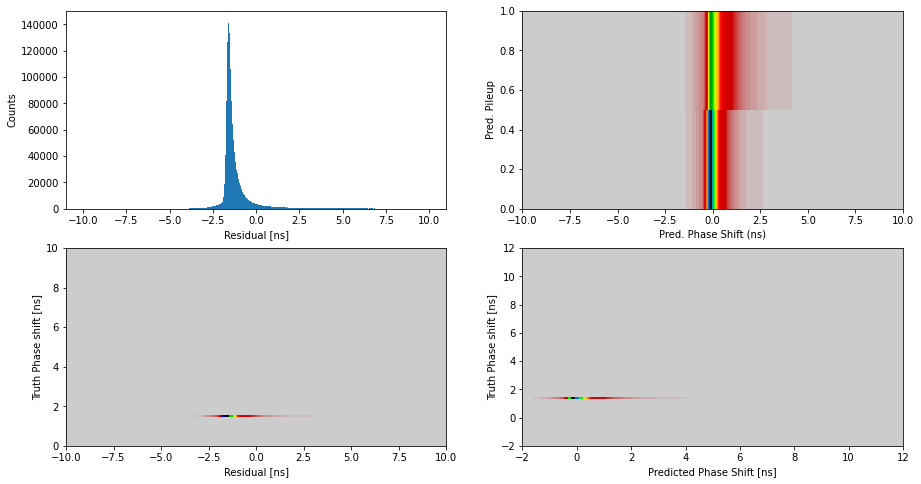

In [25]:
import matplotlib.pyplot as plt
pres = []
for i in range(len(test_y_hat[1])):
  pres.append(test_y_hat[1,i]-test_p[i])
pres = np.array(pres)

print(pres.shape,type(test_a))

import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(2, 2 ,figsize=(15, 8))
# n = np.random.randint(0, test_x.shape[0])

# ax[0][0].hist2d(test_y[:,1],test_y_hat[:,1],bins=2)
# ax[0][0].set_xlabel("Real Pileup")
# ax[0][0].set_ylabel("Predicted Pileup")

# ax[0][1].plot(pres,test_a, 'o', color='black',alpha=0.5)
# a1 = [[pres[i],test_a[i]] for i in range(len(pres))]
ax[0][1].hist2d(test_y_hat[1][:,0],test_y_hat[0][:,0],bins=(1000,2),range=((-10,10),(0,1)),cmap='nipy_spectral_r')
# ax[0][1].set_xlim(-5,5)
ax[0][1].set_ylabel("Pred. Pileup")
ax[0][1].set_xlabel("Pred. Phase Shift (ns)")

# ax[1][1].plot(test_p,test_y_hat[1], 'o', color='black',alpha=0.5)
# a2 = [[test_p[i],test_y_hat[1,i]] for i in range(len(pres))]
ax[1][1].hist2d(test_y_hat[1][:,0],test_p[:,0],bins=(100,100),range=((-2,12),(-2,12)),cmap='nipy_spectral_r')
ax[1][1].set_ylabel("Truth Phase shift [ns]")
ax[1][1].set_xlabel("Predicted Phase Shift [ns]")

ax[0][0].hist(pres,bins=1000,range=(-10,10))#,range=(-5,5))
ax[0][0].set_xlabel("Residual [ns]")
ax[0][0].set_ylabel("Counts")

# ax[1][0].plot(pres,test_p, 'o', color='black',alpha=0.5)
# a3 = [[pres[i],test_a[i]] for i in range(len(pres))]
ax[1][0].hist2d(pres[:,0],test_p[:,0],bins=(100,100),range=((-10,10),(0,10)),cmap='nipy_spectral_r')
# ax[1][0].set_xlim(-5,5)
ax[1][0].set_ylabel("Truth Phase shift [ns]")
ax[1][0].set_xlabel("Residual [ns]")


In [26]:
pred_nopile = []
pred_pile = []
for i in range(len(test_y_hat[0])):
  if test_y_hat[0][i][0]==1:
    pred_pile.append(test_y_hat[1][i][0])
  else:
    pred_nopile.append(test_y_hat[1][i][0])


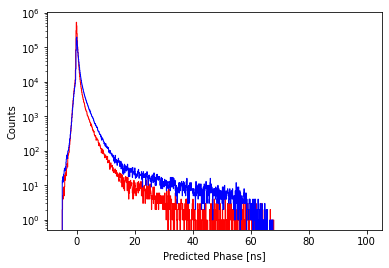

In [32]:
from scipy.optimize import curve_fit

# baselines = [t[0:40] for t in traces]
# baselines = np.array(baselines).flatten()

def fit_exp(x,A,lam):
  return np.exp(A+lam*x)

# rngeup = 15
# bins = np.linspace(-0.01,0.01,1001)
# data = np.histogram(baselines,bins=bins)
# binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
# popt, pcov = curve_fit(fit_exp,xdata=binscenters,ydata=data[0],p0=[60000.,0.0,0.01])
# print(popt)
# textstr = '\n'.join((r'$Amp=%.2f$' % (popt[0],),
#                      r'$\mu=%.2f$' % (popt[1],),
#                      r'$\sigma=%.2f$' % (popt[2],),))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# plt.hist(test_y_hat[1][:,0],bins=1000,range=(-5,10))
plt.hist(pred_nopile,bins=1000,range=(-5,100),histtype='step',color='red')
plt.hist(pred_pile,bins=1000,range=(-5,100),histtype='step',color='blue')
plt.xlabel("Predicted Phase [ns]")
plt.ylabel("Counts")
plt.yscale('log')

IndexError: invalid index to scalar variable.

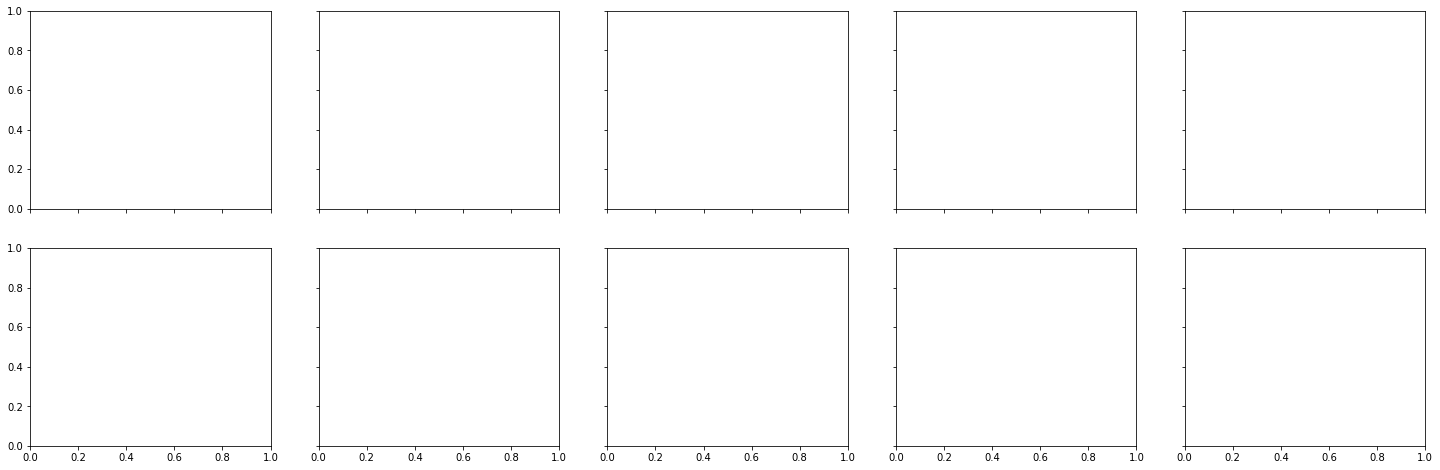

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5 ,figsize=(25, 8), sharex=True, sharey=True)
for i in range(10):
    n = np.random.randint(0, test_x.shape[0])
    # ax[i//5, i%5].plot(test_x[i][:,0], label="Pile up")
    ax[i//5, i%5].plot(test_y_hat[1][n][0][:], label="Predicted pulse 1", color='red',alpha=0.7)
    ax[i//5, i%5].plot(test_y_hat[1][n][1][:], label="Depiled pulse 2", color='blue',alpha=0.7)
    ax[i//5, i%5].plot(test_x[n][:], label="Input Pile up", color='black')
    # ax[i//5, i%5].plot(test_y[n][0][:], label="True pulse 1", color='red', linestyle='dotted')
    # ax[i//5, i%5].plot(test_y[n][1][:], label="True pulse 2", color='blue', linestyle='dotted')
    ax[i//5, i%5].set_title("Event {}".format(n))    
    ax[i//5, i%5].set_xlim(0, 300)
    ax[i//5, i%5].set_ylim(-0.1, 1.75)
    ax[i//5, i%5].legend( loc='upper right', ncol=2, fontsize=10)
    
plt.show()

In [ ]:
listOfPossPiles = []
for i in range(len(traces)):
  if(new_phase[i]>5 and new_phase[i]<10):
    listOfPossPiles.append(i)

# print(len(listOfPossPiles),listOfPossPiles[-10:],test_x.shape)
fig, ax = plt.subplots(2, 5 ,figsize=(25, 8), sharex=True, sharey=True)
for i in range(10):
    n = listOfPossPiles[i]
    # ax[i//5, i%5].plot(test_x[i][:,0], label="Pile up")
    ax[i//5, i%5].plot(test_y_hat[1][n][0][:], label="Predicted pulse 1", color='red',alpha=0.7)
    ax[i//5, i%5].plot(test_y_hat[1][n][1][:], label="Depiled pulse 2", color='blue',alpha=0.7)
    ax[i//5, i%5].plot(test_x[n][:], label="Input Pile up", color='black')
    # ax[i//5, i%5].plot(test_y[n][0][:], label="True pulse 1", color='red', linestyle='dotted')
    # ax[i//5, i%5].plot(test_y[n][1][:], label="True pulse 2", color='blue', linestyle='dotted')
    ax[i//5, i%5].set_title("Event {}".format(n))    
    ax[i//5, i%5].set_xlim(0, 300)
    ax[i//5, i%5].set_ylim(-0.1, 1.75)
    ax[i//5, i%5].legend( loc='upper right', ncol=2, fontsize=10)